In [1]:
import ROOT as r

r.gSystem.Load("PDFs/PdfDiagonalizer_cc.so")
r.gSystem.Load("PDFs/Util_cxx.so")
r.gSystem.Load("PDFs/HWWLVJRooPdfs_cxx.so")

# To surpress unwanted messages
msgservice = r.RooMsgService.instance()
msgservice.setGlobalKillBelow(r.RooFit.FATAL)

%matplotlib inline

Welcome to JupyROOT 6.08/05


In [2]:
fin = r.TFile.Open("root://cmseos.fnal.gov//store/user/rasharma/SecondStep/WWTree_2018_01_25_14h36/Hadds_for_BkgEstimation/WWTree_WJets.root")

treeIn = fin.Get("otree")

In [3]:
h1 = r.TH1F("h1","",67,170,3500)
#h1.Sumw2()
#h1.SetMinimum(0.)

cutString =  "btag0Wgt*genWeight*trig_eff_Weight*id_eff_Weight*pu_Weight*((l_pt2<0) && ((l_pt1>30.) && (abs(l_eta1)<2.5)) && ((ungroomed_PuppiAK8_jet_pt>200)&&(abs(ungroomed_PuppiAK8_jet_eta)<2.4)) && ((vbf_maxpt_j1_pt>30) && (vbf_maxpt_j2_pt>30)) && (vbf_maxpt_jj_m>500) && (nBTagJet_loose==0) && (pfMET_Corr>50) && ((PuppiAK8_jet_tau2tau1<0.55)) && ((PuppiAK8_jet_mass_so>40 && PuppiAK8_jet_mass_so<65) || (PuppiAK8_jet_mass_so>105 && PuppiAK8_jet_mass_so<150)) && (abs(vbf_maxpt_j2_eta-vbf_maxpt_j1_eta)>4.0) && (vbf_maxpt_jj_m>800) && (BosonCentrality_type0>1.0) && (abs(ZeppenfeldWL_type0/vbf_maxpt_jj_Deta)<0.3) && (abs(ZeppenfeldWH/vbf_maxpt_jj_Deta)<0.3) && (mass_lvj_type0>170))"

treeIn.Draw("mass_lvj_type0>>h1",cutString)

10803L

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


**Get histogram to RooVariable and delete the histogram**

In [4]:
rrv_x = r.RooRealVar("rrv_x","WW invariant mass",170,3500,"GeV");
dh =  r.RooDataHist("dh","plotOn test data with x",r.RooArgList(rrv_x),h1)

print "Total number of events = ",h1.Integral(),"\t Integration = ",h1.Integral("width")

h1.Delete()

Total number of events =  10788.2740961 	 Integration =  536193.324476


# Draw histogram and model extracted from background estimation code

## Fit result from background estimation code

```
=====	<ROOT.RooFitResult object ("rfresult_WJets0_xww_sb_lo_em_mlvj") at 0x75c41a0> 	======

  RooFitResult: minimized FCN value: -6865.11, estimated distance to minimum: 0.088129
                covariance matrix quality: Unknown, matrix was externally provided
                Status : MINIMIZE=0 HESSE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                  frac    1.7370e-01 +/-  2.34e-02
  rrv_c_ExpN_WJets0_xww_sb_lo_em   -5.5655e-03 +/-  1.40e-04
  rrv_c_Landau_WJets0_xww_sb_lo_em    4.8421e+02 +/-  1.73e+01
  rrv_n_ExpN_WJets0_xww_sb_lo_em   -9.7704e+02 +/-  3.17e+01
  rrv_n_Landau_WJets0_xww_sb_lo_em    1.0000e+02 +/-  1.28e-06
  rrv_number_WJets0_xww_sb_lo_em_mlvj    7.0623e+03 +/-  8.61e+01

```

* Fix the parameters of landau and ExpN to the above parameters.
* Fix all parameters and draw (its not working as expected)
* Also, I don't know how I can provide the normalization

In [11]:
rrv_c_Landau = r.RooRealVar("rrv_c_Landau","rrv_c_Landau",1.1371e+03,"GeV");
rrv_n_Landau = r.RooRealVar("rrv_n_Landau","rrv_n_Landau",1.2339e+02,"GeV");
model_landau = r.RooLandau("model_landau","model_landau",rrv_x,rrv_c_Landau,rrv_n_Landau) 

rrv_a_ExpN = r.RooRealVar("rrv_a_ExpN","rrv_a_ExpN",-6.3661e-03,"GeV");
rrv_b_ExpN = r.RooRealVar("rrv_b_ExpN","rrv_b_ExpN",-1.3944e+03,"GeV");
model_ExpN = r.RooExpNPdf("model_ExpN","model_ExpN",rrv_x,rrv_a_ExpN,rrv_b_ExpN);

frac = r.RooRealVar("frac","frac",0.1737);
#frac = r.RooRealVar("frac","frac",0.8,0.,1.);

model_pdf = r.RooAddPdf("model_pdf","model_pdf",r.RooArgList(model_landau,model_ExpN),r.RooArgList(frac))

#model_pdf.fitTo(dh,r.RooFit.Save(1),r.RooFit.Extended(1))
#model_pdf.fitTo(dh,r.RooFit.Save(1),r.RooFit.Extended(1))


frame = rrv_x.frame()
dh.plotOn(frame)
dh.statOn(frame)

model_pdf.plotOn(frame, r.RooFit.LineColor(2))

<ROOT.RooPlot object ("frame_rrv_x_8c9fd70") at 0x8c9fd70>

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


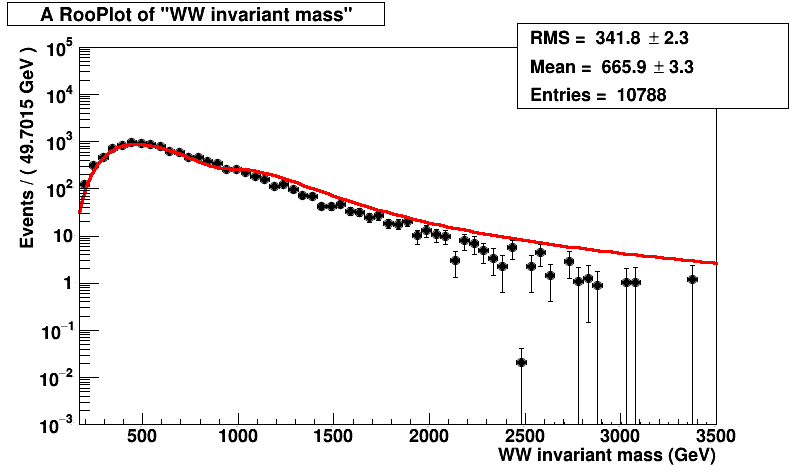

In [12]:
c1 = r.TCanvas("c1", "canvas", 800, 500)
c1.SetLogy(1)
frame.SetMaximum(1e5)
frame.SetMinimum(1e-3)
frame.Draw()
c1.Draw()

# Try to fix all parameters except fraction of the two function and then fit instead of Draw()

* This is working close to expected.

In [13]:
rrv_c_Landau = r.RooRealVar("rrv_c_Landau","rrv_c_Landau",1.1371e+03,"GeV");
rrv_n_Landau = r.RooRealVar("rrv_n_Landau","rrv_n_Landau",1.2339e+02,"GeV");
model_landau = r.RooLandau("model_landau","model_landau",rrv_x,rrv_c_Landau,rrv_n_Landau) 

rrv_a_ExpN = r.RooRealVar("rrv_a_ExpN","rrv_a_ExpN",-6.3661e-03,"GeV");
rrv_b_ExpN = r.RooRealVar("rrv_b_ExpN","rrv_b_ExpN",-1.3944e+03,"GeV");
model_ExpN = r.RooExpNPdf("model_ExpN","model_ExpN",rrv_x,rrv_a_ExpN,rrv_b_ExpN);

frac = r.RooRealVar("frac","frac",0.17,0.,1.);

model_pdf = r.RooAddPdf("model_pdf","model_pdf",r.RooArgList(model_landau,model_ExpN),r.RooArgList(frac))

model_pdf.fitTo(dh,r.RooFit.Save(1),r.RooFit.Extended(1))


frame = rrv_x.frame()
dh.plotOn(frame)
dh.statOn(frame)

model_pdf.plotOn(frame, r.RooFit.LineColor(2))

<ROOT.RooPlot object ("frame_rrv_x_91da700") at 0x91da700>

 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 frac         1.70000e-01  8.50000e-02    0.00000e+00  1.00000e+00
 **********
 **   12 **SET ERR         0.5
 **********
 **********
 **   13 **SET PRINT           1
 **********
 **********
 **   14 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   15 **MIGRAD         500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=76138.5 FROM MIGRAD    STATUS=INITIATE        4 CALLS           5 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


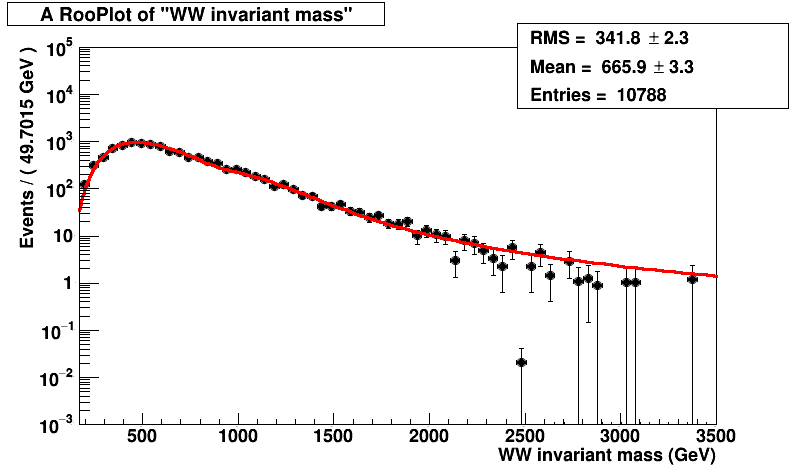

In [14]:
c1 = r.TCanvas("c1", "canvas", 800, 500)
c1.SetLogy(1)
frame.SetMaximum(1e5)
frame.SetMinimum(1e-3)
frame.Draw()
c1.Draw()

In [15]:
#fullInt = model_pdf.createIntegral(r.RooArgSet(rrv_x))
fullInt = model_pdf.createIntegral(r.RooArgSet(rrv_x),r.RooArgSet(rrv_x))
#fullInt = model_pdf.createIntegral(r.RooArgSet(rrv_x),r.RooArgSet(rrv_x),170,3500)

print fullInt.getVal()
#*1.0052e+04
#print fullInt1.getVal()*1.0052e+04

1.00000088384


# Create Histogram

Warning in <TNetXNGFile::Append>: Replacing existing TH1: model_pdf__rrv_x (Potential memory leak).


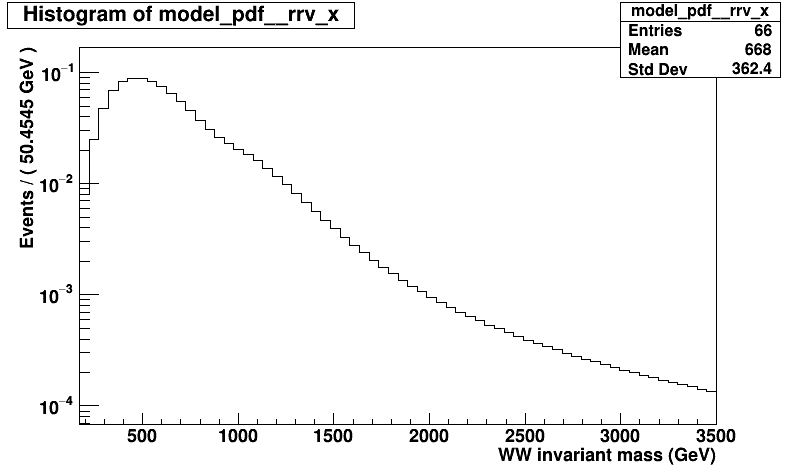

In [16]:
#datahisto = model_pdf.binnedClone(model_pdf.GetName(),"model_pdf")
#if hist:
#    hist.Delete()

hist = r.TH1F()
#hist.Sumw2()
hist = model_pdf.createHistogram("rrv_x",66)
#hist.Sumw2()
#hist.Scale(1.0052e+04)
#c1.Clear()
hist.Draw()
c1.Draw()

Warning in <TNetXNGFile::Append>: Replacing existing TH1: model_pdf__rrv_x (Potential memory leak).


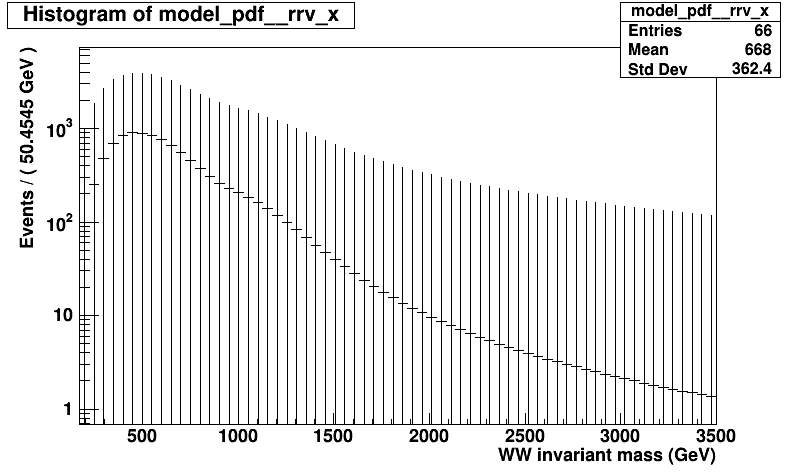

In [17]:
hist = r.TH1F()
hist.Sumw2()
hist = model_pdf.createHistogram("rrv_x",66)
#hist.Sumw2()
hist.Scale(1.0052e+04)
#c1.Clear()
hist.Draw()
c1.Draw()